In [1]:
import bempp.api
import os
import numpy as np
import time
from login import gmres, get_h
from operators import PMCHWT_operator, PMCHWT_preconditioner, mass_matrix_BC_SNC
bempp.api.global_parameters.assembly.potential_operator_assembly_type = 'dense'
from IPython import embed
from multiprocessing import Pool
import multiprocessing

In [2]:
bempp.api.__version__

'3.3.4'

In [3]:
frequency = 664E9#657.3E9 #pick a frequency from 50, 183, 243 and 664 GHz
temperature = 190 #pick a temperature from 190, 210, 230, 250, 270 
wavelength = (3E8/frequency) 
k_ext = 2 *np.pi/wavelength

if frequency == 50E9:
    if temperature == 190:
        r = 1.7643 + 0.00042j
    elif temperature == 210:
        r = 1.7695 + 0.00051j
    elif temperature == 230:
        r = 1.7746 + 0.00064j
    elif temperature == 250:
        r = 1.7797 + 0.00084j
    elif temperature == 270:
        r = 1.7848 + 0.00120j
    else: raise ValueError('Temperature chosen not available for {0}GHz frequency'.format(frequency * 1E-9))
elif frequency == 183E9:
    if temperature == 190:
        r = 1.7643 + 0.00154j
    elif temperature == 210:
        r = 1.7695 + 0.00188j
    elif temperature == 230:
        r = 1.7746 + 0.00235j
    elif temperature == 250:
        r = 1.7797 + 0.00309j
    elif temperature == 270:
        r = 1.7849 + 0.00442j
    else: raise ValueError('Temperature chosen not available for {0}GHz frequency'.format(frequency * 1E-9))
elif frequency == 243E9:
    if temperature == 190:
        r = 1.7643 + 0.00207j
    elif temperature == 210:
        r = 1.7695 + 0.00252j
    elif temperature == 230:
        r = 1.7746 + 0.00314j
    elif temperature == 250:
        r = 1.7795 + 0.00412j
    elif temperature == 270:
        r = 1.7849 + 0.00589j
    else: raise ValueError('Temperature chosen not available for {0}GHz frequency'.format(frequency * 1E-9))
elif frequency == 664E9:
    if temperature == 190:
        r = 1.7643 + 0.00649j
    elif temperature == 200:
        r = 1.7669+ 0.00706j
    elif temperature == 210:
        r = 1.7695 + 0.00771j
    elif temperature == 230:
        r = 1.7746 + 0.00940j
    elif temperature == 250:
        r = 1.7798 + 0.01209j
    elif temperature == 270:
        r = 1.7849 + 0.01690j
    else: raise ValueError('Temperature chosen not available for {0}GHz frequency'.format(frequency * 1E-9))
elif frequency == 657.3E9:
    if temperature == 190:
        r = 1.7643 + 0.00640j
    else: raise ValueError('Temperature chosen not available for {0}GHz frequency'.format(frequency * 1E-9))
else: raise ValueError('Frequency {0}GHz not available'.format(frequency * 1E-9))
    

In [4]:
size = '2mm' #choose from 2mm,4mm or 8mm
refinement_level = '10elements' # choose from 10elements, 15elements or 20elements
path_to_aggregate = os.getcwd() + '/aggregate/' + size + '/' + refinement_level #+'-version2'
number_of_scatterers = int(len(os.listdir(path_to_aggregate))/2)
print('Number of scatterers: {0}'.format(number_of_scatterers))

grids = []
for i in range(number_of_scatterers):
    rosette = bempp.api.import_grid(path_to_aggregate + '/hex' + str(i) + '.msh')
    grids.append(rosette)

Nelements = np.sum([np.shape(grid.leaf_view.elements)[1] for grid in grids])
print('Number of elements: {0}'.format(Nelements))

Number of scatterers: 8
Number of elements: 9778


In [5]:
processes = multiprocessing.cpu_count()
print('processors: {0}'.format(processes))

processors: 40


In [6]:
n_ind = [r] * number_of_scatterers
k_int = [k_ext * i for i in n_ind]

mu_ext = 1.0
mu_int = [1.0] * number_of_scatterers

Text(0.5,0,'Z axis')

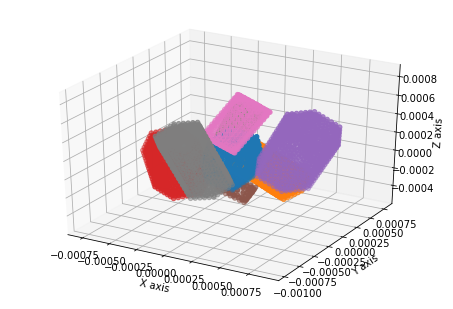

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

for i in range(number_of_scatterers):
    grid = grids[i]
    vertices = grid.leaf_view.vertices
    ax.scatter(vertices[0], vertices[1], vertices[2])

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

In [8]:
from bempp.core.common.global_parameters import global_parameters # Interface to define global_parameters for operators

quad_mu= [1,1,1,1]
quad_nu= [4,3,2,6]
# quad_nu = [10,10,10,14]
mu = 0.1
nu = 0.001
# nf = 1

################################################
# Parameters nu

parameters_nu = global_parameters()
if nu == -1:
	parameters_nu.assembly.boundary_operator_assembly_type='dense'
else:
	parameters_nu.assembly.boundary_operator_assembly_type='hmat'
parameters_nu.hmat.eps = nu
parameters_nu.quadrature.double_singular = quad_nu[3]
parameters_nu.quadrature.far.double_order = quad_nu[2]
parameters_nu.quadrature.medium.double_order = quad_nu[1]
parameters_nu.quadrature.near.double_order = quad_nu[0]

################################################
################################################
# Parameters mu near field

parameters_mu_nf = global_parameters()
if mu == -1:
	parameters_mu_nf.assembly.boundary_operator_assembly_type='dense'
else:
	parameters_mu_nf.assembly.boundary_operator_assembly_type='hmat'
parameters_mu_nf.hmat.eps = mu
parameters_mu_nf.quadrature.double_singular = quad_mu[3]
parameters_mu_nf.quadrature.far.double_order = quad_mu[2]
parameters_mu_nf.quadrature.medium.double_order = quad_mu[1]
parameters_mu_nf.quadrature.near.double_order = quad_mu[0]
# parameters_mu_nf.hmat.cutoff = nf

In [16]:
def get_memory(number_of_scatterers, operator):
    mem = 0
    for i in range(2*number_of_scatterers):
        for j in range(2*number_of_scatterers):
            op = operator[i][j]
#             print((i,j), op.memory)
            mem += op.memory
    return mem

In [9]:
# Set spaces
rwg_space = [bempp.api.function_space(grid, 'RWG', 0) for grid in grids]
snc_space = [bempp.api.function_space(grid, 'SNC', 0) for grid in grids]
bc_space = [bempp.api.function_space(grid, 'BC', 0) for grid in grids]
rbc_space = [bempp.api.function_space(grid, 'RBC', 0) for grid in grids]

b_rwg_space = [bempp.api.function_space(grid, "B-RWG", 0) for grid in grids]
b_snc_space = [bempp.api.function_space(grid, "B-SNC", 0) for grid in grids]

[PMCHWT_op, filter_operators] = PMCHWT_operator(grids, k_ext, k_int, mu_ext, mu_int, parameters = parameters_nu)
PMCHWT_pre = PMCHWT_preconditioner(grids, k_ext, k_int, mu_ext, mu_int, parameters = parameters_mu_nf)
mass_matrix = mass_matrix_BC_SNC(grids)

t0 = time.time()
pre_sf = PMCHWT_pre.strong_form()
op_wf = PMCHWT_op.weak_form()
cald_op_sf = pre_sf * mass_matrix * op_wf
ta_cald_op_sf = time.time() - t0
print('assembly time: {0} mins'.format(ta_cald_op_sf/60))

assembly time: 1.629295019308726 mins


In [17]:
print('memory op: {0}'.format(get_memory(number_of_scatterers, op_wf)/(2*1024**2)))

memory op: 1.9849815368652344


In [11]:
restart = 200
maxiter = 200
tol=1E-5

In [10]:
n_averaging = 29 #for a list of available point see files in PointDistFiles/lebedev
if n_averaging <10:
    coord = np.loadtxt('PointDistFiles/lebedev/lebedev_00{0}.txt'.format(n_averaging))
else:
    coord = np.loadtxt('PointDistFiles/lebedev/lebedev_0{0}.txt'.format(n_averaging))
w_averaging = coord[:,2] #weights
n_waves = np.shape(w_averaging)[0]
print('Number of waves: {0}'.format(np.shape(w_averaging)[0]))
phi_averaging = np.radians(coord[:,0]) #phi
theta_averaging = np.radians(coord[:,1])#theta

Number of waves: 302


In [12]:
number_of_angles = 1801

n_leb = 59
coord = np.loadtxt('PointDistFiles/lebedev/lebedev_0{0}.txt'.format(n_leb))
w_leb = coord[:,2] #weights
phi_leb = np.radians(coord[:,0]) #phi
theta_leb = np.radians(coord[:,1])#theta


In [13]:
N_gauss = 1
[angles_gauss, weights_gamma] = np.polynomial.legendre.leggauss(N_gauss)
weights_gamma = weights_gamma/2
angles_gauss = (2*np.pi)*angles_gauss/2 + (2*np.pi)/2

In [15]:
def incident_wave_func(counter_gauss, counter_lebedev):
#     counter_gauss = counters[0]
#     counter_lebedev = counters[1]
    print(counter_gauss, counter_lebedev)
    x = angles_gauss[counter_gauss]
    
    weights = w_averaging[counter_lebedev]
    theta_inc = theta_averaging[counter_lebedev]
    phi_inc = phi_averaging[counter_lebedev]
    

#     print("w = {0}, theta = {1}, phi = {2}, gamma = {3}".format(weights,theta_inc, phi_inc, x))
    incident_direction = np.array([np.sin(theta_inc) * np.cos(phi_inc), 
                                   np.sin(theta_inc) * np.sin(phi_inc), 
                                    np.cos(theta_inc)])
    vector_theta_inc = np.array([np.cos(theta_inc) * np.cos(phi_inc) * np.cos(x) - np.sin(phi_inc)*np.sin(x), 
                                 np.cos(theta_inc) * np.sin(phi_inc) * np.cos(x) + np.cos(phi_inc) * np.sin(x), 
                                 -np.sin(theta_inc) * np.cos(x)])
    vector_phi_inc = np.array([-np.sin(phi_inc) * np.cos(x) - np.cos(phi_inc) * np.cos(theta_inc) * np.sin(x), 
                               np.cos(phi_inc) * np.cos(x) - np.sin(phi_inc) * np.cos(theta_inc) * np.sin(x), 
                              np.sin(theta_inc) * np.sin(x)])
   #     print('{0}, {1}'.format(incident_direction, np.dot(vector_theta_inc, vector_phi_inc)))
    def plane_wave_phi(point):
        return vector_phi_inc * np.exp(1j * k_ext * np.dot(point, incident_direction))

    def plane_wave_theta(point):
        return vector_theta_inc * np.exp(1j * k_ext * np.dot(point, incident_direction))

    def dirichlet_trace_phi_inc(point, n, domain_index, result):
        result[:] =  np.cross(plane_wave_phi(point), n)

    def dirichlet_trace_theta_inc(point, n, domain_index, result):
        result[:] =  np.cross(plane_wave_theta(point), n)

    def plane_wave_curl_phi(point):
        return np.cross(incident_direction, vector_phi_inc) * 1j * k_ext * np.exp(1j * k_ext * np.dot(point, incident_direction))

    def plane_wave_curl_theta(point):
        return np.cross(incident_direction, vector_theta_inc) * 1j * k_ext * np.exp(1j * k_ext * np.dot(point, incident_direction))

    def neumann_trace_phi_inc(point, n, domain_index, result):
        result[:] =  1./ (1j * k_ext) * np.cross(plane_wave_curl_phi(point), n)

    def neumann_trace_theta_inc(point, n, domain_index, result):
        result[:] =  1./ (1j * k_ext) * np.cross(plane_wave_curl_theta(point), n)
    ##############################################################################
    # sovling for incident field
    ##############################################################################
    incident_dirichlet_phi = []
    incident_neumann_phi = []
    incident_dirichlet_theta = []
    incident_neumann_theta = []

    for i in range(number_of_scatterers):
        incident_dirichlet_phi.append(bempp.api.GridFunction(rwg_space[i], fun = dirichlet_trace_phi_inc))
        incident_neumann_phi.append((k_ext/mu_ext) * bempp.api.GridFunction(rwg_space[i], fun=neumann_trace_phi_inc))

        incident_dirichlet_theta.append(bempp.api.GridFunction(rwg_space[i], fun = dirichlet_trace_theta_inc))
        incident_neumann_theta.append((k_ext/mu_ext) * bempp.api.GridFunction(rwg_space[i], fun=neumann_trace_theta_inc))

    # Set RHS
    rhs_phi = number_of_scatterers * [None]
    rhs_theta = number_of_scatterers * [None]

    for i in range(number_of_scatterers):
        filter_op_wf = filter_operators[i].weak_form()
        rhs_phi[i] = filter_op_wf * (incident_dirichlet_phi[i].coefficients.tolist()+ incident_neumann_phi[i].coefficients.tolist())
        rhs_theta[i] = filter_op_wf * (incident_dirichlet_theta[i].coefficients.tolist() + incident_neumann_theta[i].coefficients.tolist())

    rhs_phi = [y for x in rhs_phi for y in x]
    rhs_theta = [y for x in rhs_theta for y in x]

    rhs_phi = pre_sf * mass_matrix * rhs_phi
    rhs_theta = pre_sf * mass_matrix * rhs_theta

    print('GMRES solve')
    t0 = time.time()
    x_phi, info_phi, iters_phi = gmres(cald_op_sf, rhs_phi, tol=tol, restart = restart, maxiter = maxiter, return_residuals = True)
    t_solve_phi = time.time() - t0
    print('{0},{1}:  solver time phi: {2} mins \n iters phi: {3}'.format(counter_gauss, counter_lebedev,t_solve_phi/60, len(iters_phi)))
#     plt.figure()
#     plt.semilogy(iters_phi)
#     plt.show()
    if len(iters_phi) == maxiter:
        raise ValueError('Maximum number of iterations reached before convergence. Choose a larger maxiter above')

    t0 = time.time()
    x_theta, info_theta, iters_theta = gmres(cald_op_sf, rhs_theta, tol=tol, restart = restart, maxiter = maxiter, return_residuals = True)
    t_solve_theta = time.time() - t0
    print('{0},{1}:  solver time theta: {2} mins \n iters theta: {3}'.format(counter_gauss, counter_lebedev,t_solve_theta/60, len(iters_theta)))
    if len(iters_theta) == maxiter:
        raise ValueError('Maximum number of iterations reached before convergence. Choose a larger maxiter above')

    scattered_dirichlet_exterior_phi = number_of_scatterers * [None]
    scattered_neumann_exterior_phi = number_of_scatterers * [None]

    scattered_dirichlet_exterior_theta = number_of_scatterers * [None]
    scattered_neumann_exterior_theta = number_of_scatterers * [None]

    sum_dofs = 0
    for i in range(number_of_scatterers):
        scattered_dirichlet_exterior_phi[i] = x_phi[2*sum_dofs: 2*sum_dofs + rwg_space[i].global_dof_count]
        scattered_neumann_exterior_phi[i] =  (mu_ext / k_ext) *  x_phi[2*sum_dofs + rwg_space[i].global_dof_count : 
                                                                   2*sum_dofs + 2*rwg_space[i].global_dof_count]

        scattered_dirichlet_exterior_theta[i] = x_theta[2*sum_dofs: 2*sum_dofs + rwg_space[i].global_dof_count]
        scattered_neumann_exterior_theta[i] =  (mu_ext / k_ext) *  x_theta[2*sum_dofs + rwg_space[i].global_dof_count : 
                                                                   2*sum_dofs + 2*rwg_space[i].global_dof_count]

        sum_dofs += rwg_space[i].global_dof_count

    ###################################################################################
    ## Computing Cext
    ###################################################################################
    far_field_phi = np.zeros((3, 1), dtype='complex128')
    far_field_theta = np.zeros((3, 1), dtype = 'complex128')

    incident_direction = np.array([[np.sin(theta_inc) * np.cos(phi_inc),
                                   np.sin(theta_inc) * np.sin(phi_inc),
                                   np.cos(theta_inc)]])

    for i in range(number_of_scatterers):

        electric_far = bempp.api.operators.far_field.maxwell.electric_field(rwg_space[i], incident_direction.T, k_ext)
        magnetic_far = bempp.api.operators.far_field.maxwell.magnetic_field(rwg_space[i], incident_direction.T, k_ext)    

        sc_N_phi = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_neumann_exterior_phi[i])
        sc_D_phi = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_dirichlet_exterior_phi[i])

        sc_N_theta = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_neumann_exterior_theta[i])
        sc_D_theta = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_dirichlet_exterior_theta[i])

        far_field_phi += -electric_far * sc_N_phi - magnetic_far * sc_D_phi
        far_field_theta += -electric_far * sc_N_theta - magnetic_far * sc_D_theta


    
    Cext_phi = 4*np.pi/(k_ext * np.linalg.norm(vector_phi_inc)**2) * np.imag(np.dot(far_field_phi[:,0], np.conjugate(vector_phi_inc)))
    Cext_theta = 4*np.pi/(k_ext * np.linalg.norm(vector_theta_inc)**2) * np.imag(np.dot(far_field_theta[:,0],np.conjugate(vector_theta_inc)))
    Cext = 0.5* (Cext_phi + Cext_theta)
    
    ###################################################################################
    ## Computing Csca
    ###################################################################################
    coord_leb_Csca = np.vstack([np.sin(theta_leb)*np.cos(phi_leb), 
                                np.sin(theta_leb)*np.sin(phi_leb), 
                                np.cos(theta_leb)])
    ff_quad_phi = np.zeros(np.shape(coord_leb_Csca), dtype='complex128')
    ff_quad_theta = np.zeros(np.shape(coord_leb_Csca), dtype = 'complex128')
    bempp.api.global_parameters.assembly.potential_operator_assembly_type = 'dense'

    R_theta = np.array([[np.cos(theta_inc), 0 ,np.sin(theta_inc)], [0,1,0], [-np.sin(theta_inc), 0, np.cos(theta_inc)]])
    R_phi = np.array([[np.cos(phi_inc), -np.sin(phi_inc), 0], [np.sin(phi_inc), np.cos(phi_inc), 0], [0,0,1]])
    R_x = np.array([[np.cos(x), -np.sin(x), 0], [np.sin(x), np.cos(x), 0], [0,0,1]])

    beta_matrix = np.dot(R_phi, np.dot(R_theta, R_x))
    coord_leb_Csca = np.dot(beta_matrix, coord_leb_Csca)
    
    for i in range(number_of_scatterers):

        electric_far = bempp.api.operators.far_field.maxwell.electric_field(rwg_space[i], coord_leb_Csca, k_ext)
        magnetic_far = bempp.api.operators.far_field.maxwell.magnetic_field(rwg_space[i], coord_leb_Csca, k_ext)    

        sc_N_phi = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_neumann_exterior_phi[i])
        sc_D_phi = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_dirichlet_exterior_phi[i])

        sc_N_theta = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_neumann_exterior_theta[i])
        sc_D_theta = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_dirichlet_exterior_theta[i])

        ff_quad_phi += -electric_far * sc_N_phi - magnetic_far * sc_D_phi
        ff_quad_theta += -electric_far * sc_N_theta - magnetic_far * sc_D_theta

    ff_quad_phi_mag = np.linalg.norm(ff_quad_phi, axis = 0)**2
    ff_quad_theta_mag = np.linalg.norm(ff_quad_theta, axis = 0)**2

    Int_phi = 4*np.pi * np.dot(ff_quad_phi_mag,w_leb)
    Int_theta = 4*np.pi * np.dot(ff_quad_theta_mag,w_leb)# the 4*np.pi factor comes from the quadrature rule

    Csca_phi = 1/np.linalg.norm(vector_phi_inc)**2 * Int_phi
    Csca_theta = 1/np.linalg.norm(vector_theta_inc)**2 * Int_theta

    Csca = 0.5 * (Csca_phi + Csca_theta)
    w = Csca/Cext
    print('w: {0}'.format(w))
    ############################################################################################
    ## Computing g
    ############################################################################################
#     coord_leb_g = np.vstack([np.sin(theta_leb)*np.cos(phi_leb), 
#                              np.sin(theta_leb)*np.sin(phi_leb), 
#                              np.cos(theta_leb)])
#     ff_quad_phi = np.zeros(np.shape(coord_leb_g), dtype='complex128')
#     ff_quad_theta = np.zeros(np.shape(coord_leb_g), dtype = 'complex128')
      
#     coord_leb_g = np.dot(beta_matrix, coord_leb_g)

#     for i in range(number_of_scatterers):
#         electric_far = bempp.api.operators.far_field.maxwell.electric_field(rwg_space[i], coord_leb_g, k_ext)
#         magnetic_far = bempp.api.operators.far_field.maxwell.magnetic_field(rwg_space[i], coord_leb_g, k_ext)

#         sc_N_phi = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_neumann_exterior_phi[i])
#         sc_D_phi = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_dirichlet_exterior_phi[i])

#         sc_N_theta = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_neumann_exterior_theta[i])
#         sc_D_theta = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_dirichlet_exterior_theta[i])

#         ff_quad_phi += -electric_far * sc_N_phi - magnetic_far * sc_D_phi
#         ff_quad_theta += -electric_far * sc_N_theta - magnetic_far * sc_D_theta

#     ff_quad_phi_mag = np.linalg.norm(ff_quad_phi, axis = 0)**2
#     ff_quad_theta_mag = np.linalg.norm(ff_quad_theta, axis = 0)**2

#     Int_g_phi = 4*np.pi * np.dot(ff_quad_phi_mag * np.cos(theta_leb), w_leb)
#     Int_g_theta = 4 * np.pi * np.dot(ff_quad_theta_mag * np.cos(theta_leb), w_leb)

#     print(np.shape(ff_quad_phi_mag), np.shape(np.dot(incident_direction,coord_leb_g)), np.shape(w_leb))
#     print(np.shape(np.dot(incident_direction,coord_leb_g)*ff_quad_phi_mag), np.shape(w_leb))
    
    Int_g_phi = 4*np.pi * np.dot(np.dot(incident_direction,coord_leb_Csca)*ff_quad_phi_mag, w_leb)
    Int_g_theta = 4 * np.pi * np.dot(np.dot(incident_direction,coord_leb_Csca)*ff_quad_theta_mag, w_leb)
    
    g_phi = 1/(np.linalg.norm(vector_phi_inc)**2 *Csca_phi) *Int_g_phi[0]
    g_theta = 1/(np.linalg.norm(vector_theta_inc)**2 *Csca_theta) *Int_g_theta[0]
    
#     print(np.linalg.norm(vector_phi_inc)**2, np.linalg.norm(vector_theta_inc)**2)
    
    g = 0.5 * (g_phi + g_theta)
#     print(Int_g_phi, Int_g_theta)
    
#     g = 0.5/Csca * (Int_g_phi + Int_g_theta)
#     print('g: {0}'.format(g))
    ##################################################################
    ## Computing phase matrix
    ##################################################################
    far_field_phi = np.zeros((3, number_of_angles), dtype='complex128')
    far_field_theta = np.zeros((3, number_of_angles), dtype = 'complex128')

    angles_theta = np.linspace(0 , np.pi , number_of_angles)
    angles_phi = 0. #+ phi_inc

    scattering_direction = np.array([np.sin(angles_theta) * np.cos(angles_phi),
                                     np.sin(angles_theta) * np.sin(angles_phi),
                                     np.cos(angles_theta)])
    scattering_direction = np.dot(beta_matrix, scattering_direction)
    
    for i in range(number_of_scatterers):
        electric_far = bempp.api.operators.far_field.maxwell.electric_field(rwg_space[i],scattering_direction, k_ext)
        magnetic_far = bempp.api.operators.far_field.maxwell.magnetic_field(rwg_space[i],scattering_direction, k_ext)

        sc_N_phi = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_neumann_exterior_phi[i])
        sc_D_phi = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_dirichlet_exterior_phi[i])

        sc_N_theta = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_neumann_exterior_theta[i])
        sc_D_theta = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_dirichlet_exterior_theta[i])

        far_field_phi += -electric_far * sc_N_phi - magnetic_far * sc_D_phi
        far_field_theta += -electric_far * sc_N_theta - magnetic_far * sc_D_theta
    
  
    vector_theta_sca = np.array([np.cos(angles_theta)*np.cos(angles_phi),
                                np.cos(angles_theta)*np.sin(angles_phi),
                                -np.sin(angles_theta)])
    vector_phi_sca = np.array([-np.sin(angles_phi)*np.ones(number_of_angles),
                               np.cos(angles_phi)*np.ones(number_of_angles),
                               np.zeros(number_of_angles)])
    
    vector_theta_sca = np.dot(beta_matrix, vector_theta_sca)
    vector_phi_sca = np.dot(beta_matrix, vector_phi_sca)
    
    a11 = []
    a12 = []
    a21 = []
    a22 = []

    for i in range(number_of_angles):
        a11.append(np.dot(vector_theta_sca[:,i], far_field_theta[:,i]))
        a12.append(np.dot(vector_theta_sca[:,i], far_field_phi[:,i]))
        a21.append(np.dot(vector_phi_sca[:,i], far_field_theta[:,i]))
        a22.append(np.dot(vector_phi_sca[:,i], far_field_phi[:,i]))
    
     
    S11 = np.array(a11)
    S12 = np.array(a12)
    S21 = np.array(a21)
    S22 = np.array(a22)

   
    Z11 = 0.5 * (abs(S11)**2 + abs(S12)**2 + abs(S21)**2 + abs(S22)**2)
    Z12 = 0.5*(abs(S11)**2-abs(S22)**2+abs(S21)**2-abs(S12)**2)
    Z13 = -np.real(S11*np.conjugate(S12)+S22*np.conjugate(S21))
    Z14 = -np.imag(S11*np.conjugate(S12)-S22*np.conjugate(S21))
    Z21 = 0.5*(abs(S11)**2-abs(S22)**2-abs(S21)**2+abs(S12)**2)
    Z22 = 0.5*(abs(S11)**2+abs(S22)**2-abs(S21)**2-abs(S12)**2)
    Z23 = -np.real(S11*np.conjugate(S12)-S22*np.conjugate(S21))
    Z24 = -np.imag(S11*np.conjugate(S12)+S22*np.conjugate(S21))
    Z31 = -np.real(S11*np.conjugate(S21)+S22*np.conjugate(S12))
    Z32 = -np.real(S11*np.conjugate(S21)-S22*np.conjugate(S12))
    Z33 = np.real(np.conjugate(S11)*S22+S12*np.conjugate(S21))
    Z34 = np.imag(S11*np.conjugate(S22)+S21*np.conjugate(S12))
    Z41 = -np.imag(np.conjugate(S11)*S21+np.conjugate(S12)*S22)
    Z42 = -np.imag(np.conjugate(S11)*S21-np.conjugate(S12)*S22)
    Z43 = np.imag(S22*np.conjugate(S11)-S12*np.conjugate(S21))
    Z44 = np.real(np.conjugate(S11)*S22-S12*np.conjugate(S21))
    
    Cbsca = Z11[-1] * 4 * np.pi

    return (counter_gauss,counter_lebedev, weights, theta_inc, phi_inc, len(iters_phi), len(iters_theta), t_solve_phi/60, t_solve_theta/60, 
            Cext, Csca, w, g, Cbsca, Z11, Z12, Z13, Z14, Z21, Z22, Z23, Z24, Z31, Z32, Z33, Z34, Z41, Z42, Z43, Z44)

In [ ]:
starttime = time.time()
if __name__ == '__main__':
    p = Pool(processes=processes)
    a = p.starmap(incident_wave_func, [(counter1,counter2) for counter1 in range(N_gauss) for counter2 in range(np.shape(w_averaging)[0])])
    p.close()
    p.join()

results = []
for i in a:
    results.append(i)
endtime = time.time()
print('Total time: {0} mins'.format((endtime - starttime)/60))
a = results

0 8
0 10
0 0
0 4
0 14
0 2
0 16
0 6
0 12
0 20
0 18
0 26
0 32
0 28
0 38
0 30
0 34
0 24
0 40
0 22
0 36
0 42
0 44
0 46
0 50
0 52
0 48
0 56
0 58
0 54
0 64
0 66
0 62
0 68
0 76
0 72
0 70
0 78
0 60
0 74
GMRES solve
GMRES solve
GMRES solve
GMRES solve
GMRES solve
GMRES solve
GMRES solve
GMRES solve
GMRES solve
GMRES solve
GMRES solve
GMRES solve
GMRES solve
GMRES solve
GMRES solve
GMRES solve
GMRES solve
GMRES solve
GMRES solve
GMRES solve
GMRES solve
GMRES solve
GMRES solve
GMRES solve
GMRES solve
GMRES solve
GMRES solve
GMRES solve
GMRES solve
GMRES solve
GMRES solve
GMRES solve
GMRES solve
GMRES solve
GMRES solve
GMRES solve
GMRES solve
GMRES solve
GMRES solve
GMRES solve
0,30:  solver time phi: 47.516703542073564 mins 
 iters phi: 107
0,40:  solver time phi: 47.66928685506185 mins 
 iters phi: 108
0,54:  solver time phi: 47.78238223791122 mins 
 iters phi: 108
0,10:  solver time phi: 47.8427478035291 mins 
 iters phi: 108
0,62:  solver time phi: 47.883840545018515 mins 
 iters phi: 108
0,74

 iters phi: 110
0,27:  solver time phi: 48.477342462539674 mins 
 iters phi: 109
0,59:  solver time phi: 47.822107489903765 mins 
 iters phi: 108
0,67:  solver time phi: 48.87970316807429 mins 
 iters phi: 110
0,39:  solver time phi: 48.691641175746916 mins 
 iters phi: 109
0,63:  solver time phi: 48.8548028588295 mins 
 iters phi: 110
0,41:  solver time phi: 48.96155382394791 mins 
 iters phi: 110
0,37:  solver time phi: 48.645445009072624 mins 
 iters phi: 109
0,43:  solver time phi: 48.712752842903136 mins 
 iters phi: 109
0,23:  solver time phi: 48.66427291631699 mins 
 iters phi: 109
0,29:  solver time phi: 48.338062993685405 mins 
 iters phi: 109
0,5:  solver time phi: 49.64852600097656 mins 
 iters phi: 111
0,69:  solver time phi: 48.90352437098821 mins 
 iters phi: 109
0,79:  solver time phi: 48.4830748518308 mins 
 iters phi: 108
0,49:  solver time phi: 49.0251550634702 mins 
 iters phi: 109
0,45:  solver time phi: 49.238157614072165 mins 
 iters phi: 110
0,13:  solver time ph

 iters phi: 110
0,152:  solver time phi: 48.57136192719142 mins 
 iters phi: 109
0,128:  solver time phi: 50.33771285613378 mins 
 iters phi: 113
0,150:  solver time phi: 48.68120219707489 mins 
 iters phi: 108
0,140:  solver time phi: 49.5575492421786 mins 
 iters phi: 111
0,144:  solver time phi: 49.295372462272645 mins 
 iters phi: 110
0,154:  solver time phi: 48.88200116157532 mins 
 iters phi: 110
0,156:  solver time phi: 49.14443036317825 mins 
 iters phi: 110
0,158:  solver time phi: 49.16402108271917 mins 
 iters phi: 110
0,82:  solver time theta: 48.5089736978213 mins 
 iters theta: 109
w: 0.9265748834213302
0,86:  solver time theta: 49.100636827945706 mins 
 iters theta: 110
0,92:  solver time theta: 48.49297282298406 mins 
 iters theta: 109
0,80:  solver time theta: 49.14553320010503 mins 
 iters theta: 109
0,88:  solver time theta: 47.41821646293004 mins 
 iters theta: 106
0,84:  solver time theta: 49.768886117140454 mins 
 iters theta: 111
0,94:  solver time theta: 48.6371

 iters theta: 110
0 160
0,151:  solver time theta: 47.60354007085164 mins 
 iters theta: 107
w: 0.9288340118811935
0,137:  solver time theta: 49.156194690863295 mins 
 iters theta: 110
0,147:  solver time theta: 47.20142251650493 mins 
 iters theta: 107
w: 0.9294046373730556
w: 0.9323317921342907
0,139:  solver time theta: 48.60977436304093 mins 
 iters theta: 109
0,123:  solver time theta: 49.13529781500498 mins 
 iters theta: 109
w: 0.9308420214749281
0 162
0,111:  solver time theta: 49.200226525465645 mins 
 iters theta: 110
0,99:  solver time theta: 49.02531549930573 mins 
 iters theta: 110
w: 0.9290763504319423
0,97:  solver time theta: 48.59257689317067 mins 
 iters theta: 110
0,103:  solver time theta: 49.86029835144679 mins 
 iters theta: 111
0,101:  solver time theta: 49.33819784323374 mins 
 iters theta: 111
0,149:  solver time theta: 48.69403379360835 mins 
 iters theta: 110
0,107:  solver time theta: 48.22064943313599 mins 
 iters theta: 109
0 164
0,125:  solver time theta:

w: 0.9353502518374246
0,210:  solver time theta: 48.52251800298691 mins 
 iters theta: 109
w: 0.9394856292517465
0,204:  solver time theta: 49.28135934670766 mins 
 iters theta: 110
w: 0.9459817918478229
w: 0.9306738713229169
w: 0.9271016298334811
0 163
0 175
0,212:  solver time theta: 48.95860470533371 mins 
 iters theta: 110
w: 0.9383172532115878
0 167
w: 0.9307388320822082
GMRES solve
0 173
0,186:  solver time theta: 49.09445588588714 mins 
 iters theta: 110
GMRES solve
w: 0.9376520351016574
0,216:  solver time theta: 47.78050780296326 mins 
 iters theta: 109
0,234:  solver time theta: 47.60622058312098 mins 
 iters theta: 108
w: 0.9376647379519819
0 199
0,222:  solver time theta: 48.511661970615386 mins 
 iters theta: 110
0,208:  solver time theta: 48.46686288913091 mins 
 iters theta: 110
w: 0.9303697300466797
w: 0.9447343359807933
0 171
w: 0.9447496018904101
0,226:  solver time theta: 47.79902197122574 mins 
 iters theta: 109
0,228:  solver time theta: 48.27683372100194 mins 
 it

w: 0.9337039263384787
0 260
0,187:  solver time theta: 48.75306894381841 mins 
 iters theta: 110
0 262
0 264
0 266
0 268
w: 0.9403449062146079
0 270
w: 0.9202419914351999
w: 0.9291616949476773
GMRES solve
0 272
w: 0.9337485136776167
w: 0.9252148536404878
w: 0.9408627461825595
0 274
GMRES solve
GMRES solve
0 276
w: 0.9329518269593595
0 278
GMRES solve
w: 0.9330945156465686
0 280
GMRES solve
GMRES solve
w: 0.9322006280606258
0,237:  solver time theta: 48.58123095432917 mins 
 iters theta: 111
GMRES solve
GMRES solve
0 282
0 284
w: 0.9337541486150215
0 286
GMRES solve
0 288
GMRES solve
0,231:  solver time theta: 48.15852724313736 mins 
 iters theta: 110
GMRES solve
0 290
0 292
GMRES solve
0 294
GMRES solve
GMRES solve
0 296
GMRES solve
0 298
GMRES solve
0,239:  solver time theta: 48.444052867094676 mins 
 iters theta: 111
0 300
GMRES solve
w: 0.928531859009247
GMRES solve
GMRES solve
w: 0.925695807175515
GMRES solve
GMRES solve
GMRES solve
GMRES solve
GMRES solve
w: 0.9367814899337581
0,2

In [ ]:
weights_averaging = []
theta_inc = []
phi_inc = []
iterations_theta = []
iterations_phi = []
solver_time_phi = []
solver_time_theta = []
Cext = []
Csca = []
Cbsca = []
g = []
w = []
Z11 = []
Z12 = []
Z13 = []
Z14 = []
Z21 = []
Z22 = []
Z23 = []
Z24 = []
Z31 = []
Z32 = []
Z33 = []
Z34 = []
Z41 = []
Z42 = []
Z43 = []
Z44 = []

a.sort(key=lambda element: (element[0], element[1]) )
# for i in a:
#     print(i[0], i[1])
weights_averaging.append([r[2] for r in a])
theta_inc.append([r[3] for r in a])
phi_inc.append([r[4] for r in a])
iterations_theta.append([r[6] for r in a])
iterations_phi.append([r[5] for r in a])
solver_time_phi.append([r[7] for r in a])
solver_time_theta.append([r[8] for r in a])
Cext.append([r[9] for r in a])
Csca.append([r[10] for r in a])
w.append([r[11] for r in a])
g.append([r[12] for r in a])
Cbsca.append([r[13] for r in a])
Z11.append([r[14] for r in a])
Z12.append([r[15] for r in a])
Z13.append([r[16] for r in a])
Z14.append([r[17] for r in a])
Z21.append([r[18] for r in a])
Z22.append([r[19] for r in a])
Z23.append([r[20] for r in a])
Z24.append([r[21] for r in a])
Z31.append([r[22] for r in a])
Z32.append([r[23] for r in a])
Z33.append([r[24] for r in a])
Z34.append([r[25] for r in a])
Z41.append([r[26] for r in a])
Z42.append([r[27] for r in a])
Z43.append([r[28] for r in a])
Z44.append([r[29] for r in a])

Cext = np.reshape(np.array(Cext[0]), (N_gauss, n_waves))
Csca = np.reshape(np.array(Csca[0]), (N_gauss, n_waves))
Cbsca = np.reshape(np.array(Cbsca[0]), (N_gauss, n_waves))
g = np.reshape(np.array(g[0]), (N_gauss, n_waves))
w = np.reshape(np.array(w[0]), (N_gauss, n_waves))

Cext_avg = np.dot(weights_gamma,np.dot(Cext, w_averaging))
Csca_avg = np.dot(weights_gamma,np.dot(Csca, w_averaging))
Cbsca_avg = np.dot(weights_gamma,np.dot(Cbsca, w_averaging))
g_avg = np.dot(weights_gamma,np.dot(g, w_averaging))
w_avg = np.dot(weights_gamma,np.dot(w, w_averaging))

Z11 = np.transpose(np.reshape(np.array(Z11[0]), (N_gauss, n_waves, number_of_angles)), axes = (0,2,1))
Z12 = np.transpose(np.reshape(np.array(Z12[0]), (N_gauss, n_waves, number_of_angles)), axes = (0,2,1))
Z13 = np.transpose(np.reshape(np.array(Z13[0]), (N_gauss, n_waves, number_of_angles)), axes = (0,2,1))
Z14 = np.transpose(np.reshape(np.array(Z14[0]), (N_gauss, n_waves, number_of_angles)), axes = (0,2,1))
Z21 = np.transpose(np.reshape(np.array(Z21[0]), (N_gauss, n_waves, number_of_angles)), axes = (0,2,1))
Z22 = np.transpose(np.reshape(np.array(Z22[0]), (N_gauss, n_waves, number_of_angles)), axes = (0,2,1))
Z23 = np.transpose(np.reshape(np.array(Z23[0]), (N_gauss, n_waves, number_of_angles)), axes = (0,2,1))
Z24 = np.transpose(np.reshape(np.array(Z24[0]), (N_gauss, n_waves, number_of_angles)), axes = (0,2,1))
Z31 = np.transpose(np.reshape(np.array(Z31[0]), (N_gauss, n_waves, number_of_angles)), axes = (0,2,1))
Z32 = np.transpose(np.reshape(np.array(Z32[0]), (N_gauss, n_waves, number_of_angles)), axes = (0,2,1))
Z33 = np.transpose(np.reshape(np.array(Z33[0]), (N_gauss, n_waves, number_of_angles)), axes = (0,2,1))
Z34 = np.transpose(np.reshape(np.array(Z34[0]), (N_gauss, n_waves, number_of_angles)), axes = (0,2,1))
Z41 = np.transpose(np.reshape(np.array(Z41[0]), (N_gauss, n_waves, number_of_angles)), axes = (0,2,1))
Z42 = np.transpose(np.reshape(np.array(Z42[0]), (N_gauss, n_waves, number_of_angles)), axes = (0,2,1))
Z43 = np.transpose(np.reshape(np.array(Z43[0]), (N_gauss, n_waves, number_of_angles)), axes = (0,2,1))
Z44 = np.transpose(np.reshape(np.array(Z44[0]), (N_gauss, n_waves, number_of_angles)), axes = (0,2,1))

Z11_avg = np.dot(weights_gamma, np.dot(Z11, w_averaging))
Z12_avg = np.dot(weights_gamma, np.dot(Z12, w_averaging))
Z13_avg = np.dot(weights_gamma, np.dot(Z13, w_averaging))
Z14_avg = np.dot(weights_gamma, np.dot(Z14, w_averaging))
Z21_avg = np.dot(weights_gamma, np.dot(Z21, w_averaging))
Z22_avg = np.dot(weights_gamma, np.dot(Z22, w_averaging))
Z23_avg = np.dot(weights_gamma, np.dot(Z23, w_averaging))
Z24_avg = np.dot(weights_gamma, np.dot(Z24, w_averaging))
Z31_avg = np.dot(weights_gamma, np.dot(Z31, w_averaging))
Z32_avg = np.dot(weights_gamma, np.dot(Z32, w_averaging))
Z33_avg = np.dot(weights_gamma, np.dot(Z33, w_averaging))
Z34_avg = np.dot(weights_gamma, np.dot(Z34, w_averaging))
Z41_avg = np.dot(weights_gamma, np.dot(Z41, w_averaging))
Z42_avg = np.dot(weights_gamma, np.dot(Z42, w_averaging))
Z43_avg = np.dot(weights_gamma, np.dot(Z43, w_averaging))
Z44_avg = np.dot(weights_gamma, np.dot(Z44, w_averaging))

In [ ]:
path_to_result = os.getcwd() + '/results/' + size + '/temperature' + str(temperature) + '/'
if not os.path.exists(path_to_result):
    os.makedirs(path_to_result)
    
outF = open(path_to_result + '/timings_{0:.2}_{1}leb_{2}gauss.txt'.format(refinement_level, n_waves, N_gauss), 'w')
outF.write('number of elements: {0}'.format(Nelements))
outF.write('\n')
outF.write('number of scatterers: {0}'.format(number_of_scatterers))
outF.write('\n')
outF.write('number of waves: {0}'.format(np.shape(w_averaging)[0]))
outF.write('\n')
outF.write('number of Gauss points: {0}'.format(N_gauss))
outF.write('\n')
outF.write('assembly time (mins): {0}'.format(ta_cald_op_sf/60))
outF.write('\n')
outF.write('Cext avg: {0}'.format(Cext_avg))
outF.write('\n')
outF.write('Csca avg: {0}'.format(Csca_avg))
outF.write('\n')
outF.write('Cbsca avg: {0}'.format(Cbsca_avg))
outF.write('\n')
outF.write('g avg: {0}'.format(g_avg))
outF.write('\n')
outF.write('w avg: {0}'.format(w_avg))
outF.write('\n')
outF.write('solver time phi (mins): {0}'.format(solver_time_phi))
outF.write('\n')
outF.write('solver time theta (mins): {0}'.format(solver_time_theta))
outF.write('\n')
outF.write('Iterations phi: {0}'.format(iterations_phi))
outF.write('\n')
outF.write('Iterations theta: {0}'.format(iterations_theta))
outF.write('\n')
outF.write('Total parallel time (mins): {0}'.format((endtime - starttime)/60))
outF.write('\n')
outF.write('Cext: {0}'.format(Cext))
outF.write('\n')
outF.write('Csca: {0}'.format(Csca))
outF.write('\n')
outF.write('Cbsca: {0}'.format(Cbsca))
outF.write('\n')
outF.write('g: {0}'.format(g))
outF.write('\n')
outF.write('w: {0}'.format(w))
outF.write('\n')
outF.close()

np.savetxt(path_to_result + '/Z11_{0:.2}_{1}leb_{2}gauss.txt'.format(refinement_level, n_waves, N_gauss), Z11_avg, fmt="%e")
np.savetxt(path_to_result + '/Z12_{0:.2}_{1}leb_{2}gauss.txt'.format(refinement_level, n_waves, N_gauss), Z12_avg, fmt="%e")
np.savetxt(path_to_result + '/Z21_{0:.2}_{1}leb_{2}gauss.txt'.format(refinement_level, n_waves, N_gauss), Z21_avg, fmt="%e")
np.savetxt(path_to_result + '/Z22_{0:.2}_{1}leb_{2}gauss.txt'.format(refinement_level, n_waves, N_gauss), Z22_avg, fmt="%e")
np.savetxt(path_to_result + '/Z33_{0:.2}_{1}leb_{2}gauss.txt'.format(refinement_level, n_waves, N_gauss), Z33_avg, fmt="%e")
np.savetxt(path_to_result + '/Z34_{0:.2}_{1}leb_{2}gauss.txt'.format(refinement_level, n_waves, N_gauss), Z34_avg, fmt="%e")
np.savetxt(path_to_result + '/Z43_{0:.2}_{1}leb_{2}gauss.txt'.format(refinement_level, n_waves, N_gauss), Z43_avg, fmt="%e")
np.savetxt(path_to_result + '/Z44_{0:.2}_{1}leb_{2}gauss.txt'.format(refinement_level, n_waves, N_gauss), Z44_avg, fmt="%e")